# Prediction of the production volume of enterprises

**Project description**

Statistical information is one of the core components of the state information resource. Important political decisions are made on the basis of it. It gives an adequate assessment of key economic and social indicators, which cover all the sides of state development. 

Using Machine learning methods in Statistical offices can improve the quality of basic statistical data producing official statistics. Methods of Machine learning are able to train a model on the basis of historical data and then to predict this value for the appropriate period. If the predicted value differs extensively from the real one, then data should be returned to the adjustment to a respondent.

**The goal of the project:** to predict the volume of heat energy production of one anonymized enterprise.

**Input data:** time series of production of heat energy of one anonymized enterprise of the Brest region beginning in January 2016 until November 2021.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import datetime
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy import stats
from itertools import product
import warnings
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\User\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Data preparation

In [2]:
#Load data
heat = pd.read_csv("heat_energy.csv")

In [3]:
heat.head()

,date,value_gc
0,2/1/2016,12000
1,3/1/2016,10110
2,4/1/2016,8800
3,5/1/2016,2900
4,6/1/2016,1000


In [4]:
heat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      71 non-null     object
 1   value_gc  71 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


In [5]:
#Change type of date column and change index
heat.date = heat.date.apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))
heat.index = heat['date']
heat.drop('date', axis='columns', inplace=True)

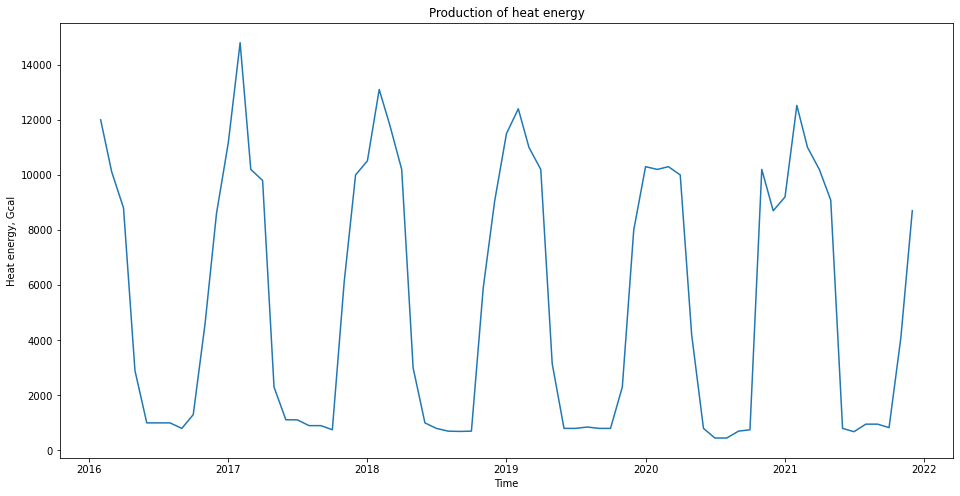

In [6]:
#Display the time series on the chart
plt.figure(figsize=(16,8))
plt.title('Production of heat energy')
plt.xlabel('Time')
plt.ylabel('Heat energy, Gcal')
plt.plot(heat)
plt.show()

Look at boxplot to find anomalies

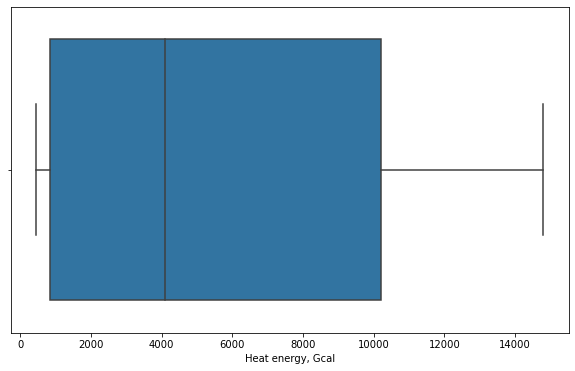

In [7]:
plt.figure(figsize=(10,6))
sns.boxplot(x=heat['value_gc'], orient='h')
plt.xlabel("Heat energy, Gcal")
plt.show()

Abnormal values that are outside the whiskers of the boxplot were not identified

## ARIMA model

C:\Users\User\AppData\Local\Temp/ipykernel_11184/315621467.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  sm.tsa.seasonal_decompose(heat,freq=12, model="additive").plot()


Dickey-Fuller test: p=0.446033


<Figure size 1008x720 with 0 Axes>

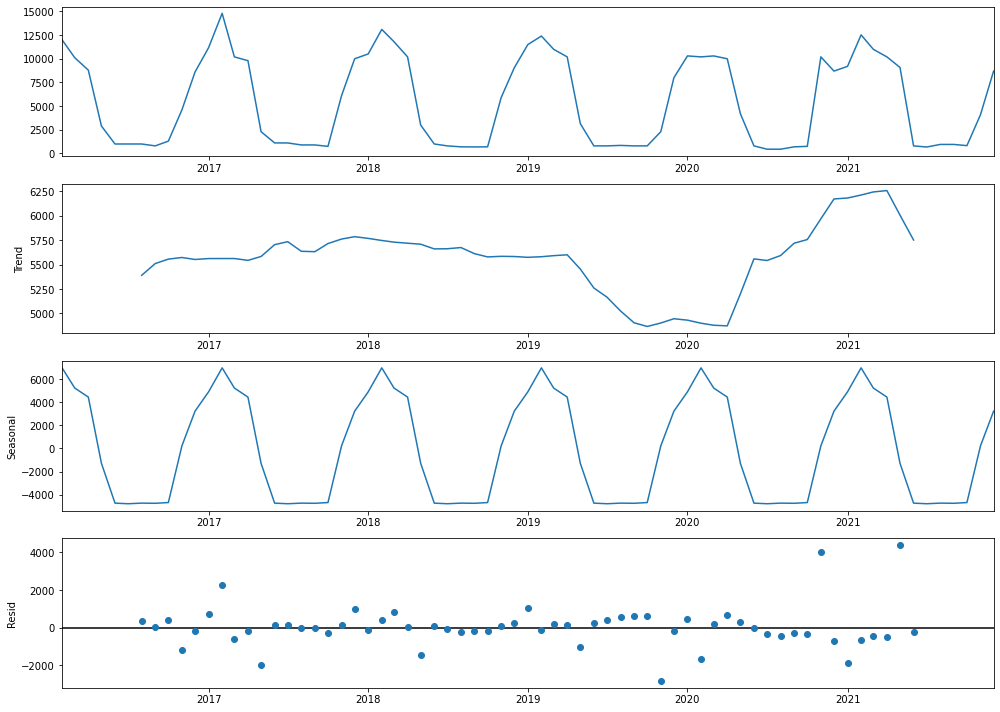

In [8]:
#Look at decomposition of time series and calculate Dickey-Fuller test
plt.figure(figsize(14,10))
sm.tsa.seasonal_decompose(heat,freq=12, model="additive").plot()
#Stationarity test
print ("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(heat)[1])

Dickey-Fuller test shows that time series is not stationar. We are going to convert the time series to stationary by Box-Cox transformation and to do seasonal differentiation.

In [9]:
heat_arima = heat.copy()

The optimal parameter of the Box-Cox transformation is: 0.117148
Dickey-Fuller test: p=0.585335


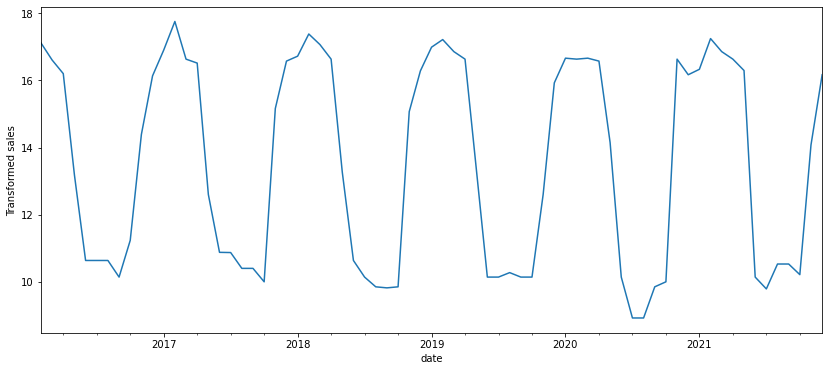

In [10]:
heat_arima['heat_box'], lmbda = stats.boxcox(heat_arima.value_gc)
plt.figure(figsize=(14,6))
heat_arima.heat_box.plot()
plt.ylabel(u'Transformed sales')
print ("The optimal parameter of the Box-Cox transformation is: %f" % lmbda)
print ("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller (heat_arima.heat_box)[1])

Dickey-Fuller test: p=0.032686


<Figure size 720x504 with 0 Axes>

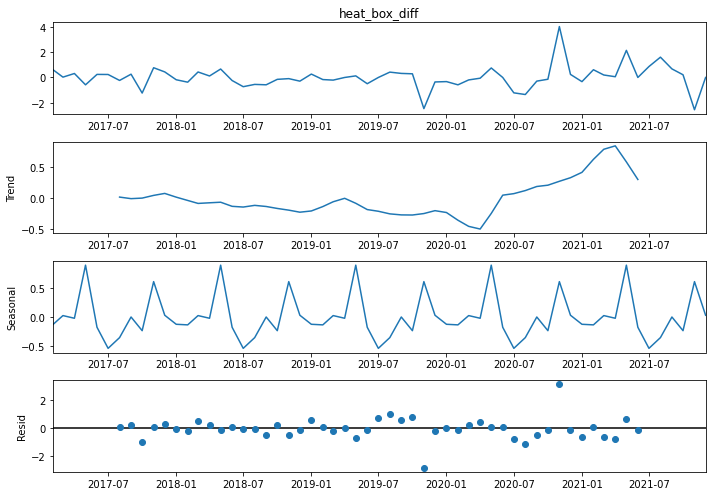

In [11]:
heat_arima['heat_box_diff'] = heat_arima.heat_box - heat_arima.heat_box.shift(12)
plt.figure(figsize(10,7))
sm.tsa.seasonal_decompose(heat_arima.heat_box_diff[12:]).plot()
print ("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller (heat_arima.heat_box_diff[12:])[1])

After this transformation Dickey-Fuller test shows that time series is stationar. Built autocorrelation function and partially autocorrelation function to select seasonal model parameters for SARIMA.

### Modelling

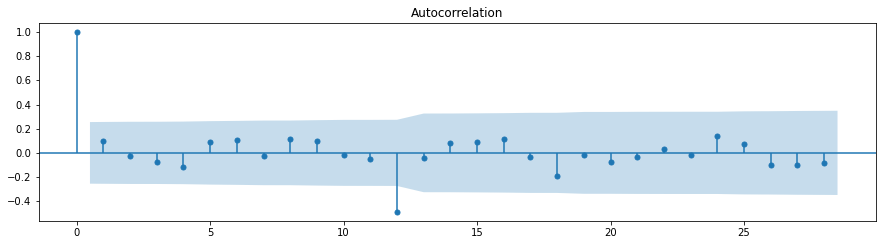

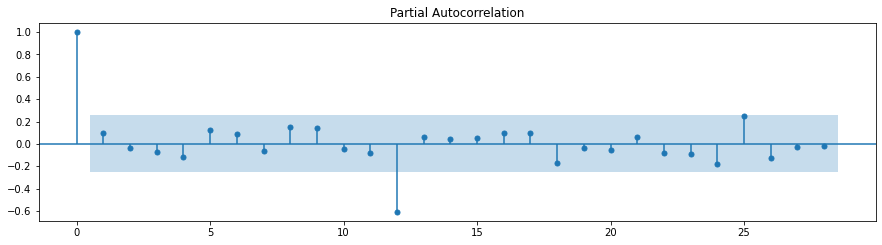

In [12]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(heat_arima.heat_box_diff[12:].values.squeeze(), lags = 28, ax = ax )
pylab.show()
plt.figure(figsize=(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(heat_arima.heat_box_diff[12:].values.squeeze(), lags = 28, ax = ax )
pylab.show()

In [13]:
ps = range(0,4)
d=0
qs = range(0,2)
Ps = range(0,2)
D = 1
Qs = range(0,2)

In [14]:
#Create list of parameters
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

32

Now we are going to select best parameters according to Akaike information criterion.

In [15]:
results = []
best_aic = float("inf")

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(heat_arima.heat_box, order = (param[0], d, param[1]), 
                                          seasonal_order = (param[2], D, param[3], 12)).fit(disp=-1) 
    
    except:
            print ('wrong parameters:', param)
            continue    
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])    
    
warnings.filterwarnings('default') 

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information 

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:5

In [16]:
#Table with 5 best models
result_table = pd.DataFrame(results)
result_table.columns=['parameters','aic']
print (result_table.sort_values(by='aic', ascending=[True]).head())
warnings.filterwarnings('ignore') 

      parameters         aic
2   (0, 0, 1, 0)  138.666469
6   (0, 1, 1, 0)  139.902390
3   (0, 0, 1, 1)  139.942168
10  (1, 0, 1, 0)  139.944749
7   (0, 1, 1, 1)  141.050896


In [17]:
#Information about the best model SARIMAX(1, 0, 1)x(1, 1, 1, 12)
print (best_model.summary())

                                SARIMAX Results                                 
Dep. Variable:                 heat_box   No. Observations:                   71
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                 -67.333
Date:                  Fri, 23 Jun 2023   AIC                            138.666
Time:                          13:26:03   BIC                            142.822
Sample:                      02-01-2016   HQIC                           140.288
                           - 12-01-2021                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6008      0.080     -7.532      0.000      -0.757      -0.444
sigma2         0.5239      0.053      9.805      0.000       0.419       0.629
Ljung-Box (L1) (Q):                 

Student's criterion: p=0.928750
Dickey-Fuller test: p=0.000000


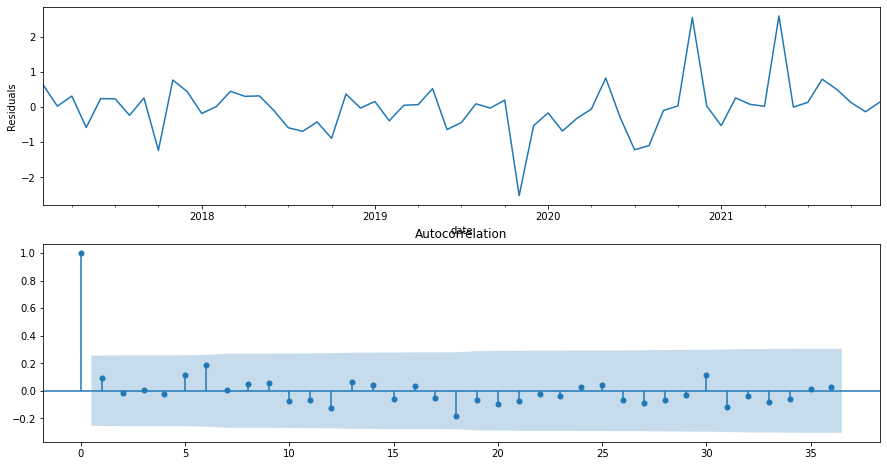

In [18]:
#The analysis of model residuals 
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[12:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[12:].values.squeeze(), lags = 36, ax=ax)
print ("Student's criterion: p=%f" % stats.ttest_1samp(best_model.resid[12:],0)[1])
print ("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])

The Dickey-Fuler test confidently rejects the hypothesis of non-stationarity of the residuals. 

In [19]:
#The fuction for inverse Box-Cox transformation
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
    warnings.filterwarnings('default') 

Now we look at how the model describes the data.

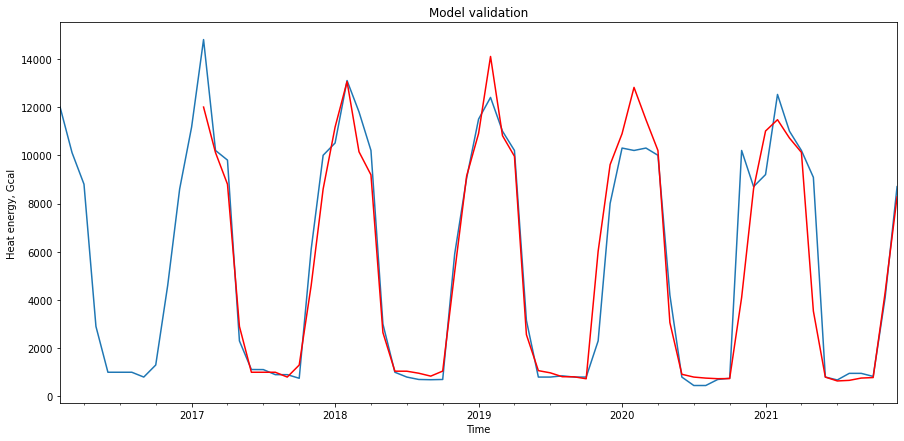

In [20]:
heat_arima['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure (figsize(15,7))
heat_arima.value_gc.plot()
heat_arima.model[12:].plot(color='r')
plt.title('Model validation')
plt.xlabel("Time")
plt.ylabel('Heat energy, Gcal')
pylab.show()

### Building prediction

In [21]:
heat2 = heat_arima[['value_gc']]
date_list = [datetime.datetime.strptime('2022-01-01', '%Y-%m-%d') + relativedelta(months = x) for x in range(0,1)]
future = pd.DataFrame (index=date_list, columns = heat2.columns)
heat2 = pd.concat([heat2, future])
heat2['forecast'] = invboxcox(best_model.predict(start=71, end=71), lmbda)
warnings.filterwarnings('ignore') 

In [22]:
#We can see predicted value on January 1, 2022
heat2[-1:]

,value_gc,forecast
2022-01-01,NaN,9847.730427


### Quality evaluation

In [23]:
#Remove the last 12 observations
heat_quality = heat_arima[:-12]

In [24]:
#Build predictions
heat_quality1 = heat_quality[['value_gc']]
date_list = [datetime.datetime.strptime('2021-01-01', '%Y-%m-%d') + relativedelta(months = x) for x in range(0,12)]
future = pd.DataFrame (index=date_list, columns = heat_quality1.columns)
heat_quality1 = pd.concat([heat_quality1, future])
heat_quality1['forecast'] = invboxcox(best_model.predict(start=59, end=71), lmbda)
warnings.filterwarnings('ignore')

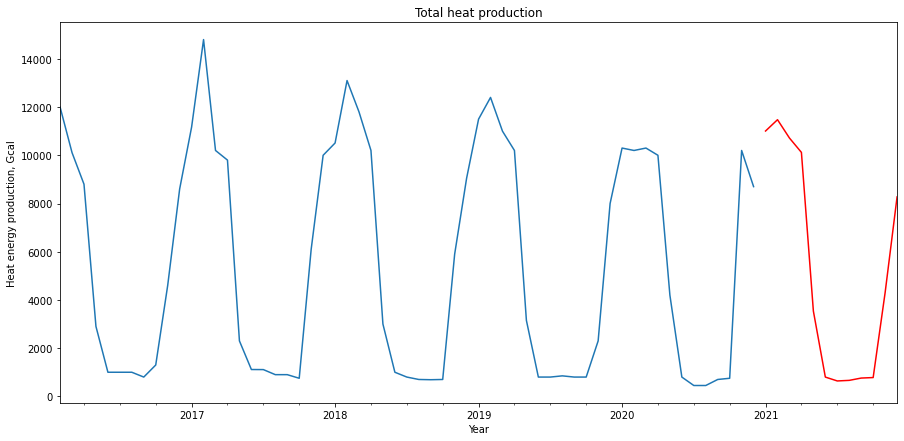

In [25]:
#Look at predictions on the chart
plt.figure(figsize(15,7))
heat_quality1.value_gc.plot()
heat_quality1.forecast.plot(color='r')
plt.title('Total heat production')
plt.ylabel('Heat energy production, Gcal')
plt.xlabel('Year')
pylab.show()

In [26]:
real_data = heat[-12:]['value_gc']
predictions = heat_quality1[-12:]['forecast']

In [27]:
print(f"Mean absolute error of ARIMA model: {round(mean_absolute_error(real_data, predictions), 1)} Gcal")
print(f"mean_absolute_percentage_error of ARIMA model: {round(mean_absolute_percentage_error(real_data, predictions) * 100, 1)} %")

Mean absolute error of ARIMA model: 831.7 Gcal
mean_absolute_percentage_error of ARIMA model: 13.8 %


## Fbprophet model

In [28]:
#Prepare data for model
heat_prophet = heat.copy()
heat_prophet = heat_prophet.reset_index()
heat_prophet.set_axis(['ds', 'y'], axis=1, inplace=True)

In [29]:
heat_prophet.head()

,ds,y
0,2016-02-01,12000
1,2016-03-01,10110
2,2016-04-01,8800
3,2016-05-01,2900
4,2016-06-01,1000


### Building prediction

In [30]:
#Train the model with yearly seasonality since the data is monthly
model = Prophet(yearly_seasonality=True) 
model.fit(heat_prophet) 
future = model.make_future_dataframe(periods=1, freq = 'MS')  
forecast = model.predict(future)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
warnings.filterwarnings("ignore")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2016-02-01,11421.109051,10082.904854,12670.287193
1,2016-03-01,10078.538254,8767.151403,11353.723252
2,2016-04-01,9482.352424,8130.071746,10751.351246
3,2016-05-01,4453.793632,3257.948668,5716.394511
4,2016-06-01,947.247884,-283.508803,2230.076963


In [31]:
#Predicted value on January 1, 2022
forecast[['ds', 'yhat']][-1:]

,ds,yhat
71,2022-01-01,10556.031607


Now we can view how the model describes the data

In [32]:
predictions = forecast.yhat[:-1]
heat_modelling = heat_prophet.copy()
heat_modelling['model'] = predictions
heat_modelling.index = heat_modelling.ds
del heat_modelling['ds']

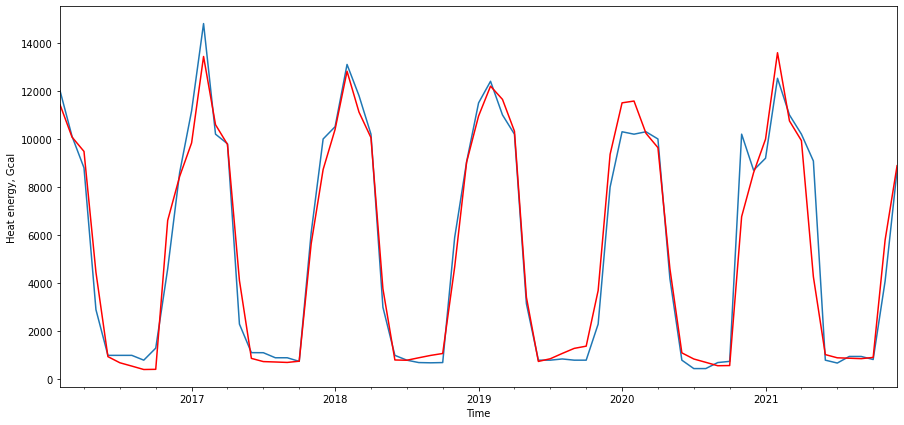

In [33]:
plt.figure(figsize(15,7))
heat_modelling.y.plot()
heat_modelling.model.plot(color='r')
plt.xlabel('Time')
plt.ylabel('Heat energy, Gcal')
pylab.show()

### Quality evaluation

In [34]:
#Remove the last 12 observations
heat_prophet_quality = heat_prophet[:-12]

In [35]:
heat_prophet_quality

,ds,y
0,2016-02-01,12000
1,2016-03-01,10110
2,2016-04-01,8800
3,2016-05-01,2900
4,2016-06-01,1000
5,2016-07-01,1000
6,2016-08-01,1000
7,2016-09-01,800
8,2016-10-01,1300
9,2016-11-01,4600


In [36]:
# Now we do the forecast for 12 months into the future 
model = Prophet(yearly_seasonality=True)
model.fit(heat_prophet_quality) 
future = model.make_future_dataframe(periods=12, freq = 'MS')  
forecast = model.predict(future)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
warnings.filterwarnings("ignore")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2016-02-01,11516.110128,10517.078094,12473.524855
1,2016-03-01,10007.014623,8975.023813,10999.347695
2,2016-04-01,9478.223844,8447.712444,10420.275550
3,2016-05-01,3421.173391,2411.704346,4424.730871
4,2016-06-01,1131.140771,165.549294,2183.278467
...,...,...,...,...
66,2021-08-01,760.499295,-245.206698,1734.676767
67,2021-09-01,731.468832,-245.591285,1731.660472
68,2021-10-01,810.473123,-224.587631,1777.017849
69,2021-11-01,6020.267509,5058.385352,6986.996599


In [37]:
predictions = forecast[-12:][['ds', 'yhat']]
predictions.index = predictions['ds']
predictions = predictions.drop('ds', axis=1)
predictions = predictions['yhat']

In [38]:
print(f"Mean absolute error of fbprophet model: {round(mean_absolute_error(real_data, predictions), 1)} Gcal")
print(f"mean_absolute_percentage_error of fbprophet model: {round(mean_absolute_percentage_error(real_data, predictions) * 100, 1)} %")

Mean absolute error of fbprophet model: 1001.9 Gcal
mean_absolute_percentage_error of fbprophet model: 19.6 %


## Recurrent neural network model

We are going to train model with 45 observations.

In [39]:
train_split = 45

In [40]:
#Standardizing the training sample
heat_train_mean = heat[:train_split].mean()
heat_train_std = heat[:train_split].std()
heat_data = (heat - heat_train_mean) / heat_train_std
heat_data = heat_data.values

We prepare the data for the model with one-dimensional input. The last 14 observations are given to the input of the model and this model should be trained to predict an indicator at the next time step. The preparation of the data for the model with one-dimensional input is schematically shown in fiqure. ![Data preparation](Data_preparation.jpg)

In [41]:
#Function for data preparation
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [42]:
univariate_past_history = 14
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(heat_data, 0, train_split,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(heat_data, train_split, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [43]:
#Check
print(x_train_uni)
print(y_train_uni)

[[[ 1.38596423]
  [ 0.9917253 ]
  [ 0.71846974]
  [-0.51222322]
  [-0.90854807]
  [-0.90854807]
  [-0.90854807]
  [-0.95026648]
  [-0.84597046]
  [-0.15761677]
  [ 0.67675134]
  [ 1.21283285]
  [ 1.97002191]
  [ 1.01049858]]

 [[ 0.9917253 ]
  [ 0.71846974]
  [-0.51222322]
  [-0.90854807]
  [-0.90854807]
  [-0.90854807]
  [-0.95026648]
  [-0.84597046]
  [-0.15761677]
  [ 0.67675134]
  [ 1.21283285]
  [ 1.97002191]
  [ 1.01049858]
  [ 0.92706177]]

 [[ 0.71846974]
  [-0.51222322]
  [-0.90854807]
  [-0.90854807]
  [-0.90854807]
  [-0.95026648]
  [-0.84597046]
  [-0.15761677]
  [ 0.67675134]
  [ 1.21283285]
  [ 1.97002191]
  [ 1.01049858]
  [ 0.92706177]
  [-0.63737843]]

 [[-0.51222322]
  [-0.90854807]
  [-0.90854807]
  [-0.90854807]
  [-0.95026648]
  [-0.84597046]
  [-0.15761677]
  [ 0.67675134]
  [ 1.21283285]
  [ 1.97002191]
  [ 1.01049858]
  [ 0.92706177]
  [-0.63737843]
  [-0.88497717]]

 [[-0.90854807]
  [-0.90854807]
  [-0.90854807]
  [-0.95026648]
  [-0.84597046]
  [-0.15761677]


In [44]:
def create_time_steps(length):
    return list(range(-length, 0))

In [45]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future Value', 'Basic Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time interval')
    return plt

Look at true future value for the first sample.

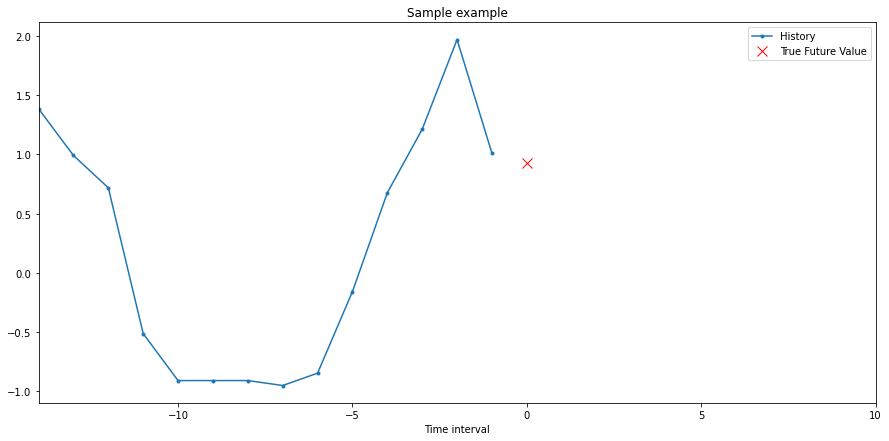

In [46]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample example')
plt.show()

In [47]:
def baseline(history):
    return np.mean(history)

Look at true future value for the first sample and base prediction.

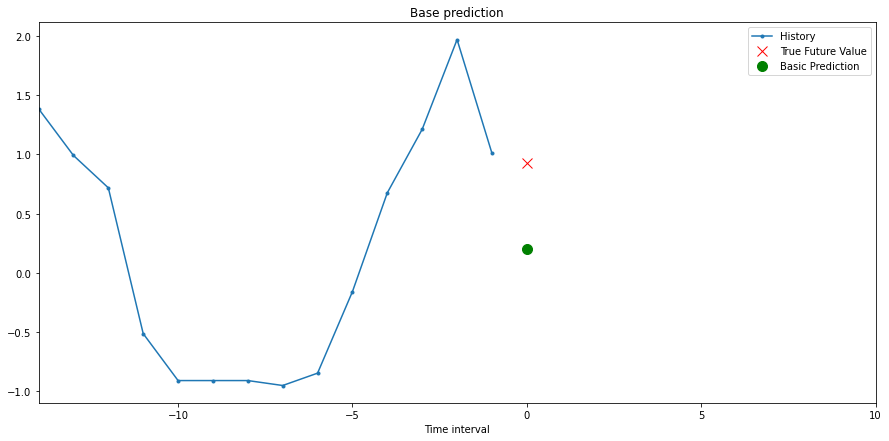

In [48]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Base prediction')
plt.show()

### Modelling

In [49]:
#Define hyperparameters
batch_size = 1
buffer_size = 10

In [50]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(buffer_size).batch(batch_size).repeat()

In [51]:
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(batch_size).repeat()

In [52]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [53]:
#Train model
EVALUATION_INTERVAL = 200
EPOCHS = 20
single_step_history= simple_lstm_model.fit(train_univariate, epochs = EPOCHS,
                      steps_per_epoch = EVALUATION_INTERVAL,
                      validation_data = val_univariate, validation_steps = 50)

Epoch 1/20
200/200 [==============================] - 5s 11ms/step - loss: 0.8692 - val_loss: 0.7698
Epoch 2/20
200/200 [==============================] - 2s 8ms/step - loss: 0.4918 - val_loss: 0.4026
Epoch 3/20
200/200 [==============================] - 1s 7ms/step - loss: 0.2304 - val_loss: 0.2660
Epoch 4/20
200/200 [==============================] - 2s 8ms/step - loss: 0.1540 - val_loss: 0.2657
Epoch 5/20
200/200 [==============================] - 1s 7ms/step - loss: 0.1297 - val_loss: 0.2687
Epoch 6/20
200/200 [==============================] - 1s 7ms/step - loss: 0.1095 - val_loss: 0.2737
Epoch 7/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0991 - val_loss: 0.2510
Epoch 8/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0902 - val_loss: 0.2429
Epoch 9/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0860 - val_loss: 0.2608
Epoch 10/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0762 - val_loss: 0.265

Look at Loss curves at training and validation steps 

In [54]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(8,5))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel("Loss")

    plt.show()

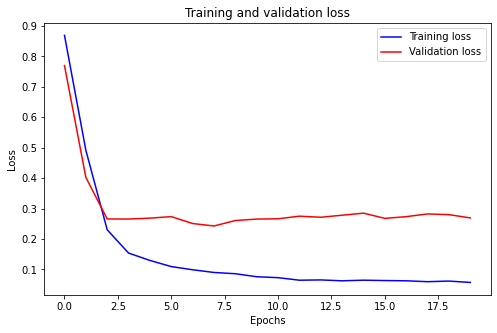

In [55]:
plot_train_history(single_step_history,
                   'Training and validation loss')

### Quality evaluation

In [56]:
real_data = []
predictions = []
for x, y in val_univariate.take(12):
    predict = simple_lstm_model.predict(x)[0][0] * heat_train_std['value_gc'] + heat_train_mean['value_gc']
    y = y.numpy()[0][0] * heat_train_std['value_gc'] + heat_train_mean['value_gc']
    predictions.append(predict)
    real_data.append(y)

In [57]:
print(f"Mean absolute error of RNN model: {round(mean_absolute_error(real_data, predictions), 1)} Gcal")
print(f"mean_absolute_percentage_error of RNN model: {round(mean_absolute_percentage_error(real_data, predictions) * 100, 1)} %")

Mean absolute error of RNN model: 1283.2 Gcal
mean_absolute_percentage_error of RNN model: 30.4 %


## Conclusions

In this project we offer to implement the methods of Machine learning during the official statistics production in order to improve the quality of statistical data. Different methods of ML are able to predict an indicator for the corresponding date on the basis of historical data. If we have a large deviation of a forecasted value from the real one the data should be returned to correction. The system can also select the best model according to its quality and also depending on time series, which include a certain statistical indicator, and depending on time series characteristics (presence of seasonality, trend, and abnormal values).

In this work, the time series of production of heat energy of one anonymized enterprise of the Brest region was chosen from the dataset. Three predictive models of Machine learning were built (ARIMA, regressive model, and recurrent neural network) on the basis of chosen time series, which predict the volume of heat energy production as of December 2021. The best quality was shown by ARIMA model from the three built models.

We conclude that for this time series the best quality shows predictive model ARIMA, but values of errors can differ for time series with other statistical indicators.